# Homework Assignment 2


## INITIALS AND COLOR TRANSFORMATION (5 PTS)

In [1]:
import skvideo.io
import skimage.color
import numpy as np
import cv2

frame_face = skvideo.io.vread('face.mp4')
print(frame_face.shape) # (# frames, Y, X, channels)

frame_baby2 = skvideo.io.vread('baby2.mp4')
print(frame_baby2.shape) # (# frames, Y, X, channels)

frame_face = frame_face.astype('double')
frame_baby2 = frame_baby2.astype('double')

YIQframe_face = skimage.color.rgb2yiq(frame_face)
YIQframe_baby2 = skimage.color.rgb2yiq(frame_baby2)

pyramid_level = 4

(301, 592, 528, 3)
(900, 352, 640, 3)


## LAPLACIAN PYRAMID (20 PTS)

In [2]:
import cv2
def gaussian_pyramid(origin_video, level=1): 
    G_tensor_list = [] # length = pyramid_level + 1
    G_tensor_list.append(origin_video)
    vid_len = origin_video.shape[0]
    print(G_tensor_list[0].shape)
    for i, frame in enumerate(origin_video):
        gauss_copy = np.ndarray(shape=origin_video.shape[1:], dtype='float')
        gauss_copy[:] = frame
        for l in range(1, pyramid_level+1):
            gauss_copy = cv2.pyrDown(gauss_copy)
            if i == 0:
                G_tensor = np.zeros((vid_len, gauss_copy.shape[0], \
                                     gauss_copy.shape[1], gauss_copy.shape[2]))
                print(G_tensor.shape)
                G_tensor_list.append(G_tensor)
            G_tensor_list[l][i] = gauss_copy
    
    return G_tensor_list

def laplacian_pyramid(gaussian_pyr, level=1):
    # generate laplacian pyramid
    L_tensor_list = []
    vid_len = gaussian_pyr[0].shape[0]
    for l in range(level-1, -1, -1):
        for i in range(vid_len):
            up_img = cv2.pyrUp(gaussian_pyr[l+1][i])
            laplacian = np.maximum(0.0, gaussian_pyr[l][i] - up_img)
            if i == 0:
                L_tensor = np.zeros((vid_len, laplacian.shape[0], laplacian.shape[1], \
                                     laplacian.shape[2]))
                print(L_tensor.shape)
            L_tensor[i] = laplacian
        L_tensor_list.append(L_tensor)
    L_tensor_list.reverse()
    return L_tensor_list
        

In [3]:
print("Size of image on each level of Gaussian pyramid")
face_G_tensor = gaussian_pyramid(YIQframe_face, 4)
print()
print("Size of image on each level of Laplacian pyramid")
face_L_tensor = laplacian_pyramid(face_G_tensor, 4)

Size of image on each level of Gaussian pyramid
(301, 592, 528, 3)
(301, 296, 264, 3)
(301, 148, 132, 3)
(301, 74, 66, 3)
(301, 37, 33, 3)

Size of image on each level of Laplacian pyramid
(301, 74, 66, 3)
(301, 148, 132, 3)
(301, 296, 264, 3)
(301, 592, 528, 3)


In [4]:
print("Size of image on each level of Gaussian pyramid")
baby2_G_tensor = gaussian_pyramid(YIQframe_baby2, 4)
print()
print("Size of image on each level of Laplacian pyramid")
baby2_L_tensor = laplacian_pyramid(baby2_G_tensor, 4)

Size of image on each level of Gaussian pyramid
(900, 352, 640, 3)
(900, 176, 320, 3)
(900, 88, 160, 3)
(900, 44, 80, 3)
(900, 22, 40, 3)

Size of image on each level of Laplacian pyramid
(900, 44, 80, 3)
(900, 88, 160, 3)
(900, 176, 320, 3)
(900, 352, 640, 3)


## TEMPORAL FILTERING (30 PTS)

In [41]:
from numpy.fft import fft, fftfreq, ifft
import matplotlib.pyplot as plt

def temporal_filtering(vid_data, lowcut, highcut, fps):
    fft_vid = fft(vid_data) # compute 1D fourier transform for frame-time axis
    sample_freq = fftfreq(vid_data.shape[0], d=1.0/fps)

    low_pass = np.abs(sample_freq - lowcut)
    high_pass = np.abs(sample_freq - highcut)
    low_bound = low_pass.argmin()
    high_bound = high_pass.argmin()
    fft_vid[-low_bound:] = 0
    fft_vid[:low_bound] = 0
    fft_vid[high_bound:-high_bound] = 0
    
    filtered_data = ifft(fft_vid, axis=0) # inverse fourier transform
    
    return filtered_data

def temporal_bandpass_filter(data, fps, freq_min, freq_max):
    data_process = np.zeros(data.shape)
    print("Applying bandpass between " + str(freq_min) + " and " + str(freq_max) + " Hz")
    for x in range(data.shape[1]):
        for y in range(data.shape[2]):
            for z in range(data.shape[3]):
                data_process[:,x,y,z] = temporal_filtering(data[:,x,y,z], freq_min, freq_max, fps)
                
    return data_process


In [42]:
filt_face_tensor = temporal_bandpass_filter(face_G_tensor[-1], 30, freq_min=0.83, freq_max=1)
filt_face_tensor *= 100

Applying bandpass between 0.83 and 1 Hz


/tmp/ipykernel_31498/2163128750.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  data_process[:,x,y,z] = temporal_filtering(data[:,x,y,z], freq_min, freq_max, fps)


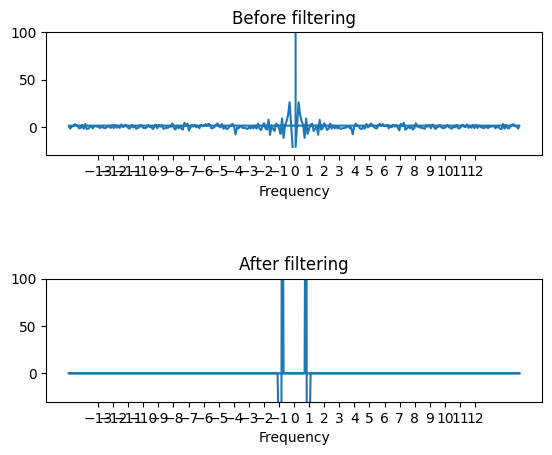

In [14]:
import random
def random_pixel(shape):
    p1 = random.randrange(shape[0])
    p2 = random.randrange(shape[1])
    p3 = random.randrange(shape[2])
    return p1, p2, p3 

p11,p12,p13 = random_pixel(face_G_tensor[-1].shape[1:])
fft_example_before = fft(face_G_tensor[-1][:, p11, p12, p13])
sample_freq = fftfreq(face_G_tensor[-1].shape[0], d=1.0/30)
fig, axes = plt.subplots(2,1)
fig.subplots_adjust(hspace=1)

axes[0].set_title("Before filtering")
axes[0].set_xlabel("Frequency")
axes[0].set_xticks(range(-13, 13, 1))
axes[0].set_ylim([-30, 100])
axes[0].plot(sample_freq, fft_example_before)

fft_example_after = fft(filt_face_tensor[:, p11, p12, p13])
axes[1].set_title("After filtering")
axes[1].set_xlabel("Frequency")
axes[1].set_xticks(range(-13, 13, 1))
axes[1].set_ylim([-30, 100])
axes[1].plot(sample_freq, fft_example_after)


In [8]:
#filt_baby2_tensor = temporal_bandpass_filter(baby2_G_tensor[-1], 30, freq_min=2.33, freq_max=2.67)
filt_baby2_tensor = temporal_bandpass_filter(baby2_G_tensor[-1], 30, freq_min=0.5, freq_max=2)
filt_baby2_tensor *= 30

Applying bandpass between 0.5 and 2 Hz


/tmp/ipykernel_31498/2163128750.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  data_process[:,x,y,z] = temporal_filtering(data[:,x,y,z], freq_min, freq_max, fps)


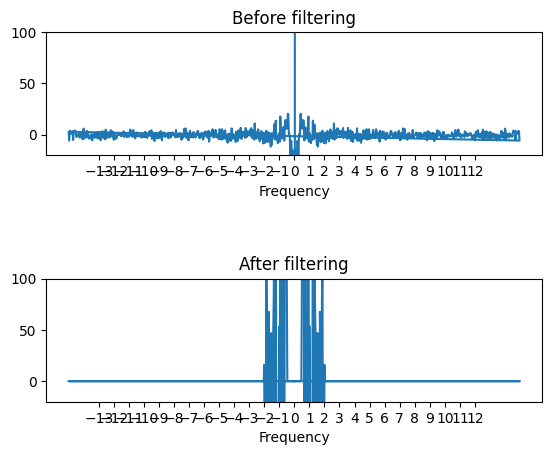

In [20]:
p21,p22,p23 = random_pixel(baby2_G_tensor[-1].shape[1:])
fft_example_before = fft(baby2_G_tensor[-1][:, p21, p22, p23])
sample_freq = fftfreq(baby2_G_tensor[-1].shape[0], d=1.0/30)
fig, axes = plt.subplots(2,1)
fig.subplots_adjust(hspace=1)

axes[0].set_title("Before filtering")
axes[0].set_xlabel("Frequency")
axes[0].set_xticks(range(-13, 13, 1))
axes[0].set_ylim([-20, 100])
axes[0].plot(sample_freq, fft_example_before)

fft_example_after = fft(filt_baby2_tensor[:, p21, p22, p23])
axes[1].set_title("After filtering")
axes[1].set_xlabel("Frequency")
axes[1].set_xticks(range(-13, 13, 1))
axes[1].set_ylim([-20, 100])
axes[1].plot(sample_freq, fft_example_after)

## IMAGE RECONSTRUCTION (20PTS, WHICH INCLUDES EVALUATION OF YOUR RESULTS)

In [44]:
import skimage.color as color

def final_laplacian_reconstruction(origin_imgs_tensor, lap_pyr, data, pyr_level):
    final_imgs = np.zeros(origin_imgs_tensor.shape) # (frame num, H, W, C)
    for frame_i in range(final_imgs.shape[0]):
        start = np.ndarray(shape=data[0].shape, dtype='float')
        start[:] = data[frame_i]
        up_img = start
        for l in range(pyr_level-1, -1, -1):
            up_img = lap_pyr[l][frame_i] + cv2.pyrUp(up_img)
        final_imgs[frame_i] = up_img
    final_imgs = origin_imgs_tensor + final_imgs # (frame num, H, W, C)
    return final_imgs


final_face_imgs = final_laplacian_reconstruction(YIQframe_face, face_L_tensor, \
                                                 filt_face_tensor, pyramid_level)
final_baby2_imgs = final_laplacian_reconstruction(YIQframe_baby2, baby2_L_tensor, \
                                                  filt_baby2_tensor, pyramid_level)


final_face_imgs = color.yiq2rgb(final_face_imgs)
final_baby2_imgs = color.yiq2rgb(final_baby2_imgs)

final_face_imgs = final_face_imgs[:,:,:,::-1] # rgb to bgr
final_baby2_imgs = final_baby2_imgs[:,:,:,::-1]


In [45]:
def video_write(vid_tensor, vid_name):
    vid_h, vid_w = vid_tensor.shape[1:3]
    print(vid_h, vid_w)
    video = cv2.VideoWriter(vid_name, fourcc=cv2.VideoWriter_fourcc(*'mp4v'), fps=30, frameSize=(vid_w, vid_h))
    for i in range(vid_tensor.shape[0]):
        video.write(np.clip(np.abs(vid_tensor[i]), 0, 255).astype(np.uint8))
    video.release()
    print(f"saved {vid_name} successfully")

In [46]:
video_write(final_face_imgs, "face_result.mp4")
video_write(final_baby2_imgs, "baby2_result.mp4")

592 528
saved face_result.mp4 successfully
352 640
saved baby2_result.mp4 successfully


## Custom video

In [47]:
import skvideo.io
import skimage.color
import numpy as np
import cv2

frame_custom = skvideo.io.vread('custom_video.mp4')
print(frame_custom.shape) # (# frames, Y, X, channels)

frame_custom = frame_custom.astype('double')

YIQframe_custom = skimage.color.rgb2yiq(frame_custom)

pyramid_level=4

(338, 720, 1280, 3)


In [48]:
custom_G_tensor = gaussian_pyramid(YIQframe_custom, pyramid_level)
custom_L_tensor = laplacian_pyramid(custom_G_tensor, pyramid_level)

(338, 720, 1280, 3)
(338, 360, 640, 3)
(338, 180, 320, 3)
(338, 90, 160, 3)
(338, 45, 80, 3)
(338, 90, 160, 3)
(338, 180, 320, 3)
(338, 360, 640, 3)
(338, 720, 1280, 3)


## EXTRACTING THE FREQUENCY BAND OF INTEREST (30PTS)

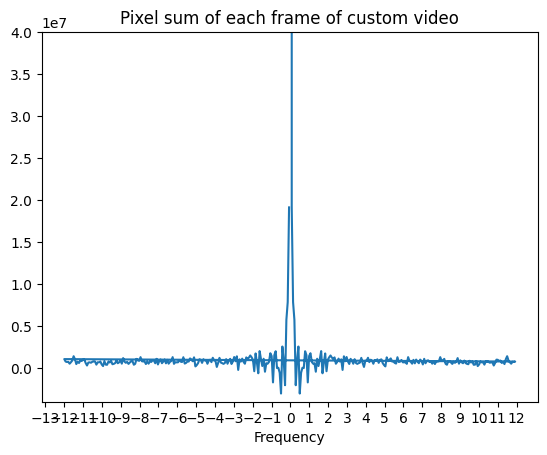

In [60]:
import matplotlib.pyplot as plt

fps = 24
pixel_sum = []
for i in range(YIQframe_custom.shape[0]):
    pixel_sum.append(YIQframe_custom[i, :, :, :].sum())

sample_freq = fftfreq(len(pixel_sum), d=1.0/fps)
sum_fft = fft(pixel_sum)
plt.figure()
plt.title("Pixel sum of each frame of custom video")
plt.xlabel("Frequency")
plt.xticks(range(-13, 13, 1))
plt.ylim([-4000000, 40000000])
plt.plot(sample_freq, sum_fft)



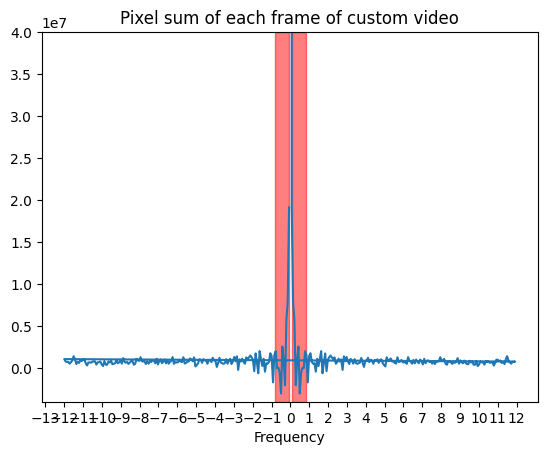

In [61]:
plt.figure()
plt.title("Pixel sum of each frame of custom video")
plt.xlabel("Frequency")
plt.xticks(range(-13, 13, 1))
plt.ylim([-4000000, 40000000])
plt.plot(sample_freq, sum_fft)
#plt.stem(sample_freq, sum_fft, markerfmt=' ')
freq_min = 5.0/60.0
freq_max = 50.0/60.0
plt.axvspan(freq_min, freq_max, alpha=0.5, color='red')
plt.axvspan(-freq_min, -freq_max, alpha=0.5, color='red')

In [51]:
filt_custom_tensor = temporal_bandpass_filter(custom_G_tensor[-1], 24, freq_min=5.0/60.0, \
                                              freq_max=50.0/60.0)
filt_custom_tensor *= 20

Applying bandpass between 0.08333333333333333 and 0.8333333333333334 Hz


/tmp/ipykernel_31498/2163128750.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  data_process[:,x,y,z] = temporal_filtering(data[:,x,y,z], freq_min, freq_max, fps)


In [52]:
final_custom_imgs = final_laplacian_reconstruction(YIQframe_custom, custom_L_tensor, filt_custom_tensor, pyramid_level)

final_custom_imgs = skimage.color.yiq2rgb(final_custom_imgs)

final_custom_imgs = final_custom_imgs[:,:,:,::-1] # rgb to bgr

In [53]:
video_write(final_custom_imgs, "custom_result.mp4")

720 1280
saved custom_result.mp4 successfully


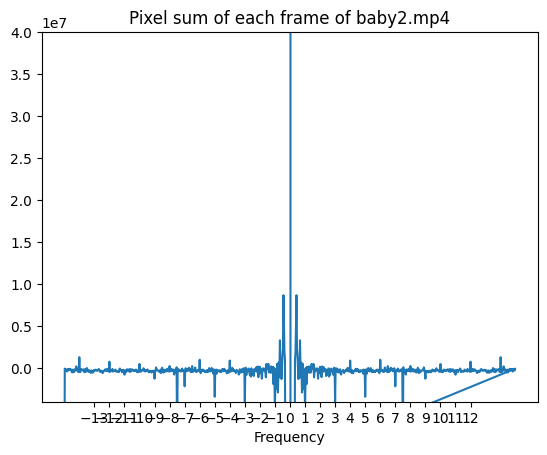

In [57]:
# this code is for extraction the frequency band of interest of baby2.mp4

import matplotlib.pyplot as plt

fps = 30
pixel_sum = []
for i in range(YIQframe_baby2.shape[0]):
    pixel_sum.append(YIQframe_baby2[i, :, :, :].sum())

sample_freq = fftfreq(len(pixel_sum), d=1.0/fps)
sum_fft = fft(pixel_sum)
plt.figure()
plt.title("Pixel sum of each frame of baby2.mp4")
plt.xlabel("Frequency")
plt.xticks(range(-13, 13, 1))
plt.ylim([-4000000, 40000000])
plt.plot(sample_freq, sum_fft)

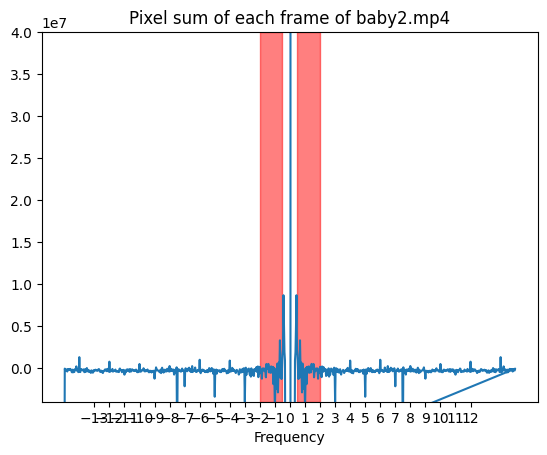

In [59]:
plt.figure()
plt.title("Pixel sum of each frame of baby2.mp4")
plt.xlabel("Frequency")
plt.xticks(range(-13, 13, 1))
plt.ylim([-4000000, 40000000])
plt.plot(sample_freq, sum_fft)
#plt.stem(sample_freq, sum_fft, markerfmt=' ')
freq_min = 0.5
freq_max = 2
plt.axvspan(freq_min, freq_max, alpha=0.5, color='red')
plt.axvspan(-freq_min, -freq_max, alpha=0.5, color='red')